## Imports and Setup

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ensure compatibility
print(f"NetworkX version: {nx.__version__}")

NetworkX version: 3.5


## Florida Food Web - Network Backboning

Compare Naive Threshold and Disparity Filter methods for network backboning. In weighted networks like food webs, edges represent interaction strengths (e.g., predation rates). Network backboning extracts the most significant connections while reducing noise. I will compare two filtering approaches: naive thresholding based on absolute weight values, and the disparity filter which accounts for local network topology.

### Load Data and Preprocessing

I will extract the largest weakly connected component to ensure network connectivity and remove self-loops as they represent non-biological interactions in food webs.

In [2]:
# Load the dataset
G_food = nx.read_weighted_edgelist("practical_class_4/FloridaFoodWeb/edges.csv", create_using=nx.DiGraph, delimiter=",")


# Get largest weakly connected component
largest_wcc = max(nx.weakly_connected_components(G_food), key=len)
G_food = G_food.subgraph(largest_wcc).copy()

# Remove self-loops
G_food.remove_edges_from(nx.selfloop_edges(G_food))

print(f"Nodes: {G_food.number_of_nodes()}, Edges: {G_food.number_of_edges()}")

Nodes: 128, Edges: 2106


### Disparity Filter vs Naive Threshold

For each significance level α (0.50, 0.10, 0.01, 0.001), I will apply the disparity filter and compute the corresponding naive threshold that retains an equivalent number of edges, enabling a fair structural comparison between methods.

In [3]:
def compute_disparity_filter_probas(G):
    edge_probas = {}
    for node in G.nodes():
        node_edges = G.edges(node, data='weight')
        k = len(node_edges)
        if k > 1:
            strength = sum([w for _, _, w in node_edges])
            for u, v, w in node_edges:
                p_ij = (1 - w / strength) ** (k - 1)
                edge_probas[(u, v)] = p_ij
        else:
            for u, v, w in node_edges:
                edge_probas[(u, v)] = 1.0
    return edge_probas

probas = compute_disparity_filter_probas(G_food)
nx.set_edge_attributes(G_food, probas, name='p_ij')

alphas = [0.50, 0.10, 0.01, 0.001]
results = {}

for alpha in alphas:
    # Disparity Filter
    edges_df = [(u, v) for u, v, d in G_food.edges(data=True) if d.get('p_ij', 1.0) < alpha]
    G_df = G_food.edge_subgraph(edges_df).copy()
    
    num_edges_target = G_df.number_of_edges()
    
    # Naive Threshold
    # Sort edges by weight descending
    sorted_edges = sorted(G_food.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    
    # Keep top N edges
    edges_naive = [(u, v) for u, v, _ in sorted_edges[:num_edges_target]]
    G_naive = G_food.edge_subgraph(edges_naive).copy()
    
    # Corresponding threshold weight (min weight in naive set)
    thresh_weight = sorted_edges[num_edges_target-1][2]['weight'] if num_edges_target > 0 else 0

    results[alpha] = {
        'G_df': G_df,
        'G_naive': G_naive,
        'edges_count': num_edges_target,
        'nodes_df': G_df.number_of_nodes(),
        'nodes_naive': G_naive.number_of_nodes(),
        'threshold_weight': thresh_weight
    }
    
    print(f"Alpha: {alpha}, Edges: {num_edges_target}, Naive Thresh: {thresh_weight:.4f}")

Alpha: 0.5, Edges: 353, Naive Thresh: 0.0129
Alpha: 0.1, Edges: 224, Naive Thresh: 0.0589
Alpha: 0.01, Edges: 157, Naive Thresh: 0.1877
Alpha: 0.001, Edges: 118, Naive Thresh: 0.4066


### Distribution Analysis Using CCDFs

I will now compare distributions (Degree Distribution, Edge Weight Distribution, Node Strength Distribution) using complementary cumulative distribution functions (CCDFs) plotted on log-log scales. This allows me to observe how well each filtering method preserves the statistical properties of the original network across degree, weight, and strength distributions.

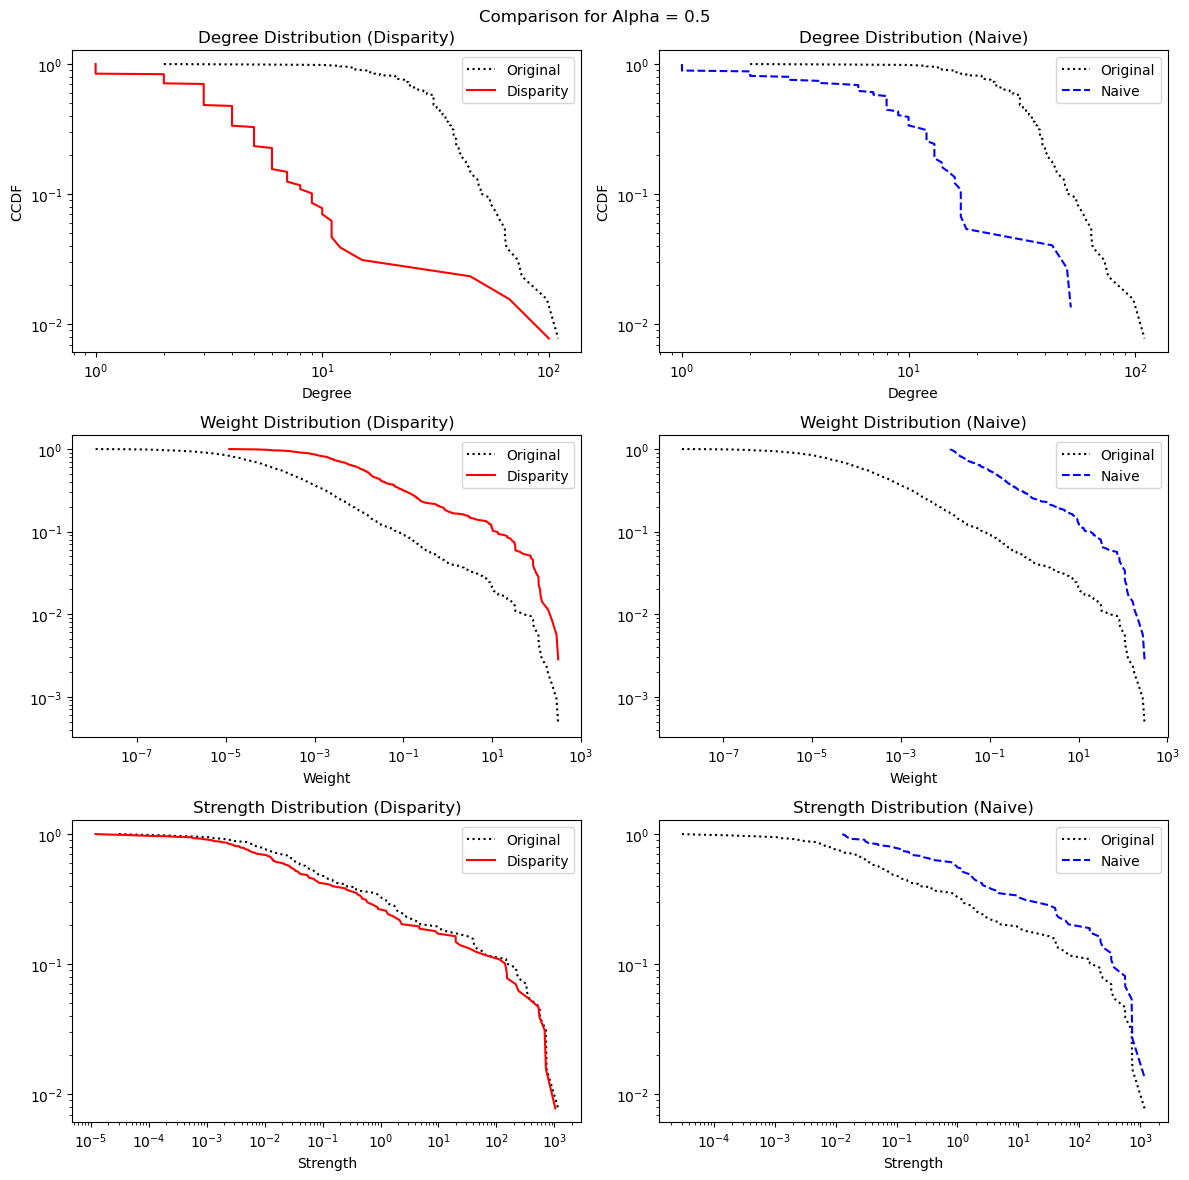

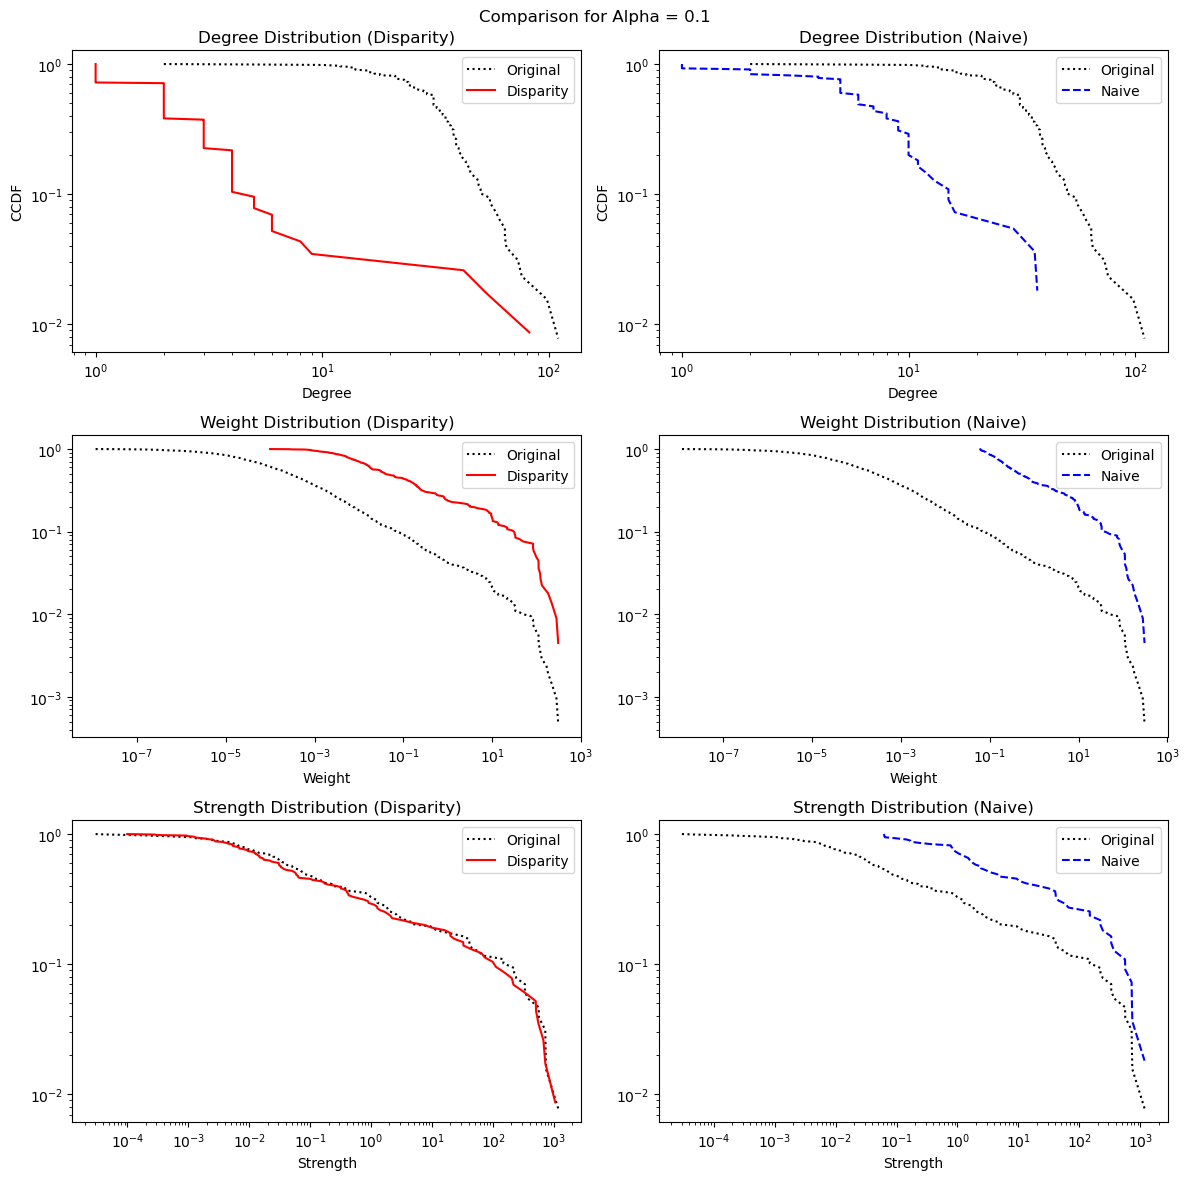

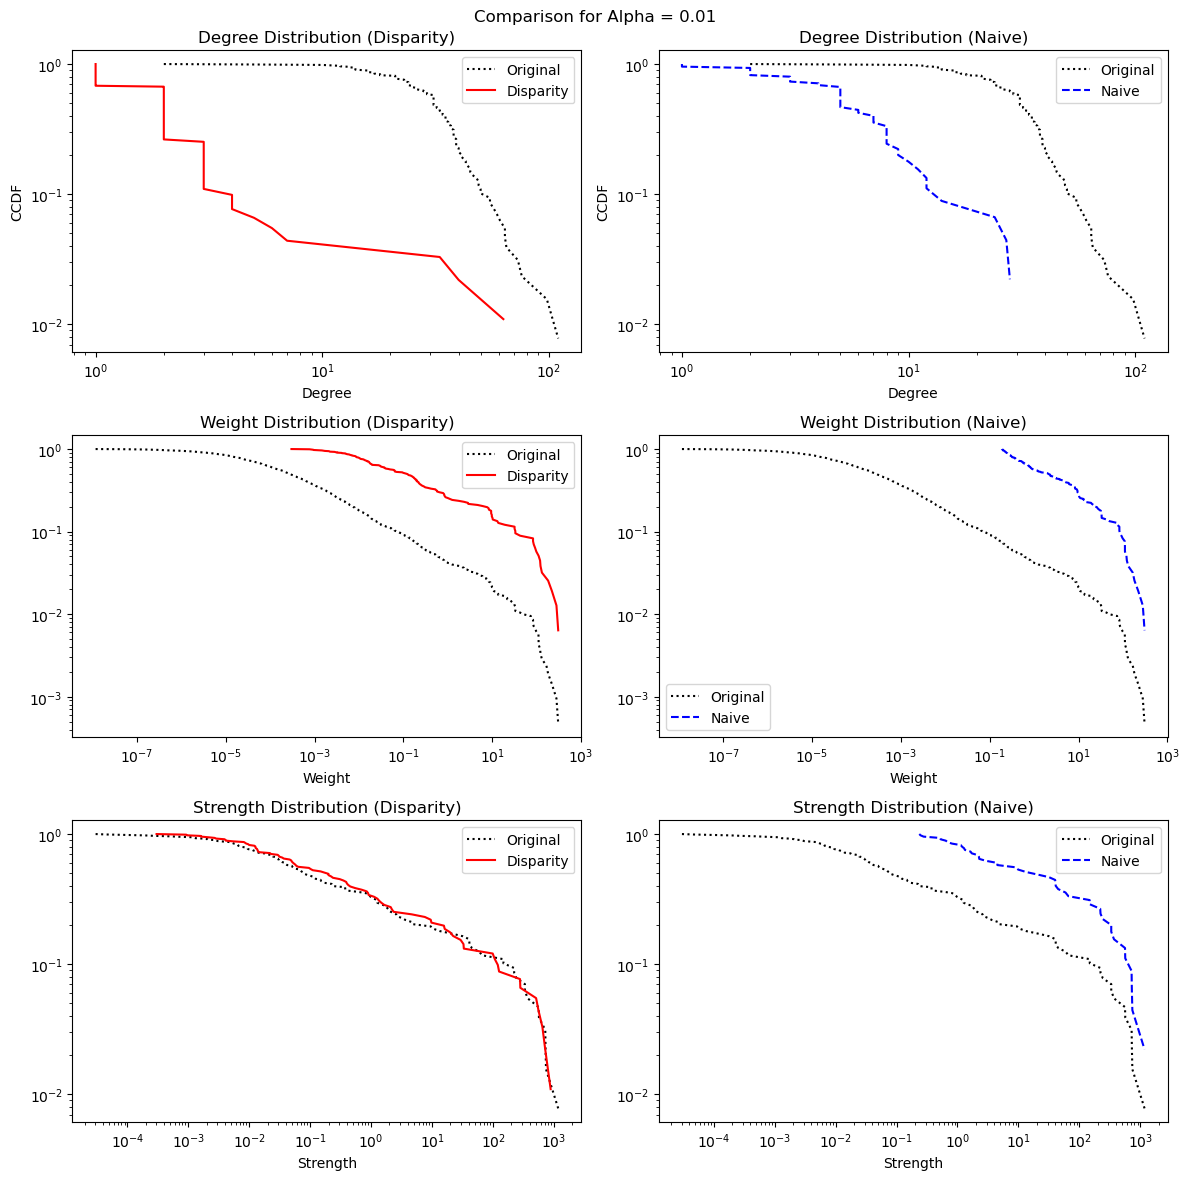

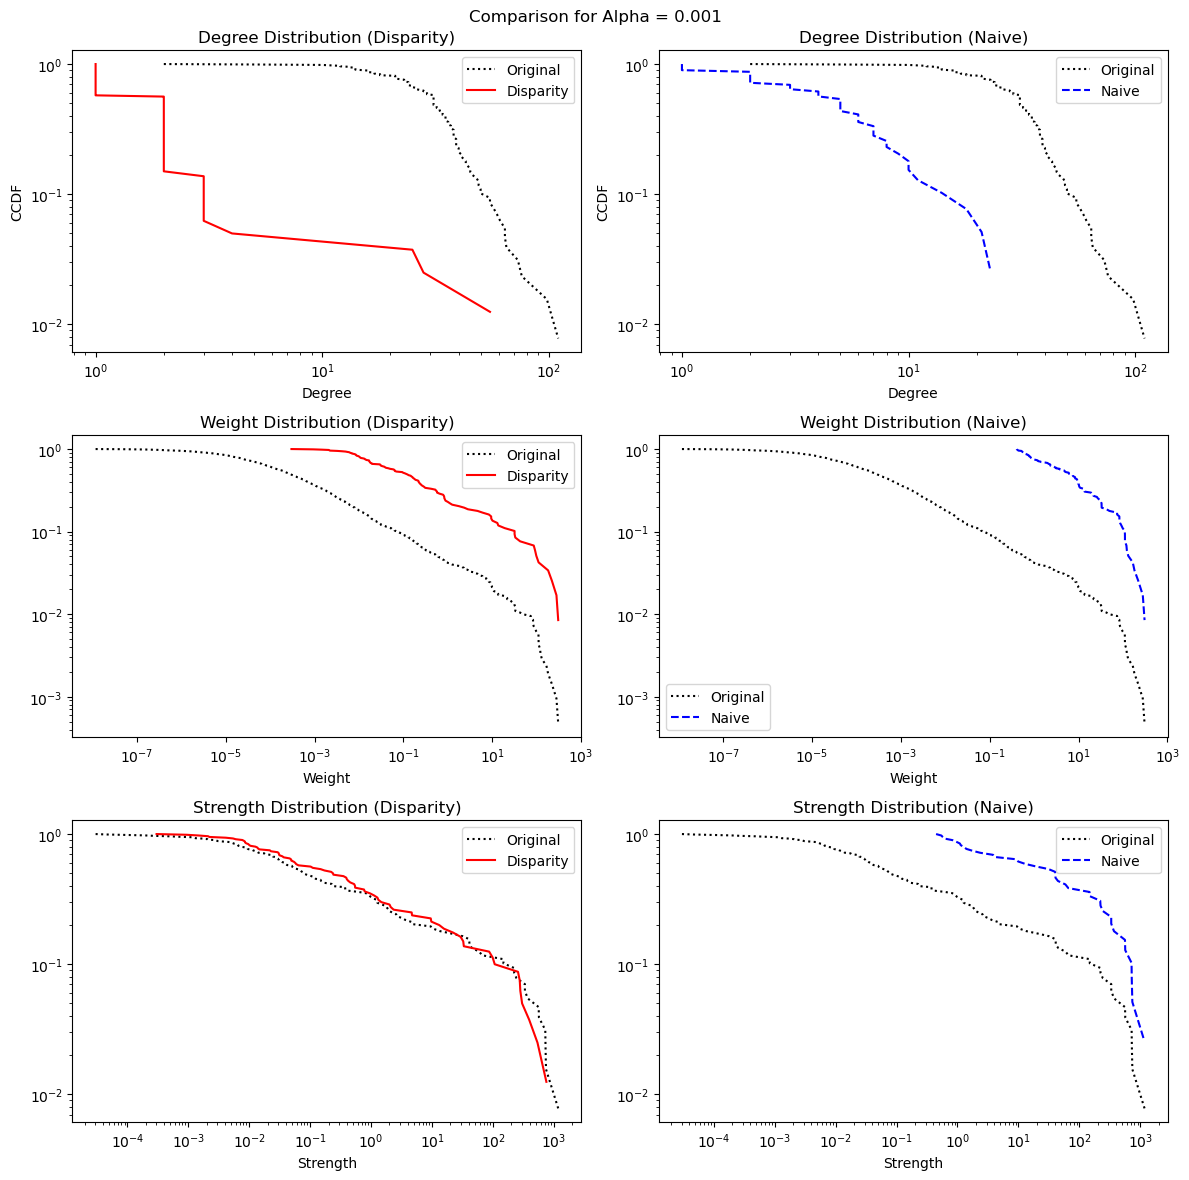

In [4]:
def plot_ccdf(data, ax, label, color, linestyle='-'):
    counter = Counter(data)
    full_range = sorted(counter.keys())
    counts = np.array([counter[k] for k in full_range])
    cdf = np.cumsum(counts) / np.sum(counts)
    ccdf = 1 - cdf
    sorted_data = np.sort(data)
    yvals = 1 - np.arange(len(sorted_data)) / len(sorted_data)
    ax.loglog(sorted_data, yvals, label=label, color=color, linestyle=linestyle)

for alpha in alphas:
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle(f"Comparison for Alpha = {alpha}")
    
    G_df = results[alpha]['G_df']
    G_naive = results[alpha]['G_naive']
    
    graphs = [(G_food, 'Original', 'black', ':'), (G_df, 'Disparity', 'red', '-'), (G_naive, 'Naive', 'blue', '--')]
    
    # Row 1: Degrees
    for i, (g_method, name, col, ls) in enumerate(graphs[1:]): # DF then Naive
        ax = axes[0, i]
        # Original
        degrees_orig = [d for n, d in G_food.degree()]
        plot_ccdf(degrees_orig, ax, 'Original', 'black', ':')
        # Method
        degrees_meth = [d for n, d in g_method.degree()]
        plot_ccdf(degrees_meth, ax, name, col, ls)
        ax.set_title(f"Degree Distribution ({name})")
        ax.set_xlabel("Degree")
        ax.set_ylabel("CCDF")
        ax.legend()
        
    # Row 2: Weights
    for i, (g_method, name, col, ls) in enumerate(graphs[1:]):
        ax = axes[1, i]
        weights_orig = [d['weight'] for u, v, d in G_food.edges(data=True)]
        plot_ccdf(weights_orig, ax, 'Original', 'black', ':')
        weights_meth = [d['weight'] for u, v, d in g_method.edges(data=True)]
        if weights_meth: plot_ccdf(weights_meth, ax, name, col, ls)
        ax.set_title(f"Weight Distribution ({name})")
        ax.set_xlabel("Weight")
        ax.legend()

    # Row 3: Strengths
    for i, (g_method, name, col, ls) in enumerate(graphs[1:]):
        ax = axes[2, i]
        # In directed weighted graph, strength usually = in_degree(weight) + out_degree(weight)
        str_orig = [val for n, val in G_food.degree(weight='weight')]
        plot_ccdf(str_orig, ax, 'Original', 'black', ':')
        str_meth = [val for n, val in g_method.degree(weight='weight')]
        plot_ccdf(str_meth, ax, name, col, ls)
        ax.set_title(f"Strength Distribution ({name})")
        ax.set_xlabel("Strength")
        ax.legend()

    plt.tight_layout()
    plt.show()

### Discussion: Comparison of Naive Threshold vs. Disparity Filter based on Observations

The two filtering methods reveal fundamentally different approaches to network reduction. The naive threshold operates globally, retaining only edges above a fixed weight cutoff, while the disparity filter preserves locally significant edges based on statistical heterogeneity within each node's neighborhood.

**Observations from the distributions:**

*Degree Distribution*: The Disparity Filter better preserves the overall structure of the degree distributio especially in the tail (low gap). In contrast, the Naive threshold produces an artificial sharp drop-off for high-degree nodes suggesting it disproportionately removes connections from hubs. This is evident across all alpha values where the Naive method diverges significantly from the original cutting off the degree distribution much earlier than the Disparity method.

*Edge Weight Distribution*: The naive method exhibits a hard cutoff in the weight distribution (all edges below the global threshold are removed) creating a truncated distribution. In contrast, the disparity filter retains a more heterogeneous mix of weights (spanning from $10^{-5}$ to $10^2$) and maintains a smoother decay. However, the disparity method shows increasing deviation from the original in the high-weight tail as alpha decreases (e.g. $\alpha=0.001$). This indicates that even very strong edges are removed if they lack local statistical significance relative to the node's total strength

*Node Strength Distribution*: The disparity filter maintains the strength distribution more faithfully across all alpha values, indicating that nodes retain a proportional representation of their total interaction capacity. In contrast, the naive method exhibits severe truncation in the low-strength regime (the left side of the distribution), while relatively preserving the high-strength tail. This confirms that the naive method disproportionately affects weak nodes, whereas the disparity filter preserves the heterogeneity of the entire system

**Implications:**

The choice between methods highlights a clear structural difference. The disparity filter excels at preserving the total interaction strength of nodes that is critical for understanding energy flow and species' overall resource availability. Furthermore, unlike the naive method, it avoids the artificial removal of highly connected species (hubs), preserving the heavy tail of the degree distribution.

The disparity filter is more appropriate for analyzing this food web because firstly it preservs node strength distributions maintains realistic energy pathways through the network, secondly weak interactions can be ecologically meaningful for specialist species, and thirdly the local statistical approach better captures species-specific interaction patterns rather than applying a uniform global criterion.

The naive threshold's systematic removal of all edges below a cutoff is overly blunt for ecological networks where interaction importance is context-dependent rather than absolute.


## Email Eu core - Community Detection

Community detection identifies densely connected groups of nodes. I will apply two optimization algorithms—Louvain and Greedy Modularity Maximization—and evaluate their performance using modularity scores and comparison with organizational metadata.

### Load and Preprocess

The email network contains 986 employees from a European research institution, with department metadata available for validating community structure.

In [5]:
# Load Graph
G_email = nx.read_edgelist("email-Eu-core.txt", nodetype=int, create_using=nx.Graph)

# Load Labels
# Format: node_id department_id
labels_df = pd.read_csv("email-Eu-core-department-labels.txt", sep=" ", names=["node", "dept"])
true_labels = dict(zip(labels_df['node'], labels_df['dept']))

# Add metadata to nodes (only for those in G_email)
nx.set_node_attributes(G_email, {n: true_labels.get(n, -1) for n in G_email.nodes()}, "dept")

# Largest Connected Component
largest_cc = max(nx.connected_components(G_email), key=len)
G_email = G_email.subgraph(largest_cc).copy()
G_email.remove_edges_from(nx.selfloop_edges(G_email))

print(f"Nodes: {G_email.number_of_nodes()}, Edges: {G_email.number_of_edges()}")

Nodes: 986, Edges: 16064


### Detect Communities

In [6]:
# Louvain
comms_louvain = nx.community.louvain_communities(G_email, seed=42)

# Greedy Modularity
comms_greedy = nx.community.greedy_modularity_communities(G_email)


### Compute Modularity

In [7]:
mod_louvain = nx.community.modularity(G_email, comms_louvain)
mod_greedy = nx.community.modularity(G_email, comms_greedy)


print(f"Louvain Modularity: {mod_louvain:.4f}")
print(f"Greedy Modularity: {mod_greedy:.4f}")



Louvain Modularity: 0.4111
Greedy Modularity: 0.3471


Better method by modularity: Louvain

### Plot Community Sizes

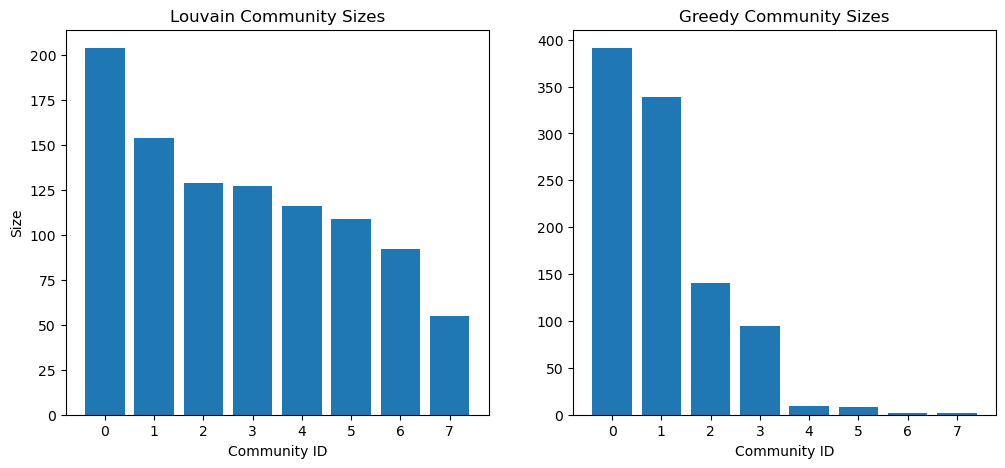

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Louvain Sizes
louvain_sizes = sorted([len(c) for c in comms_louvain], reverse=True)
axes[0].bar(range(len(louvain_sizes)), louvain_sizes)
axes[0].set_title("Louvain Community Sizes")
axes[0].set_xlabel("Community ID")
axes[0].set_ylabel("Size")

# Greedy Sizes
greedy_sizes = sorted([len(c) for c in comms_greedy], reverse=True)
axes[1].bar(range(len(greedy_sizes)), greedy_sizes)
axes[1].set_title("Greedy Community Sizes")
axes[1].set_xlabel("Community ID")

plt.show()

Louvain finds a more balanced community structure (8 communities, sizes ~50-200), while Greedy produces extreme size heterogeneity with two giant communities (~400 and ~340 nodes) dominating smaller groups. Louvain's uniformity better captures meaningful network modularity without artificial over-aggregation.

### Assessment against Metadata

I will assess community quality by comparing detected communities with department labels using the Adjusted Rand Index (ARI), which measures partition similarity while correcting for chance agreement.

In [9]:
def combination_2_manual(n):
    return n * (n - 1) / 2

def adjusted_rand_index_manual(true_labels, pred_labels):
    if len(true_labels) != len(pred_labels):
        return 0
    
    contingency = {}
    sum_a = {}
    sum_b = {}
    n = len(true_labels)
    
    for t, p in zip(true_labels, pred_labels):
        contingency[(t, p)] = contingency.get((t, p), 0) + 1
        sum_a[t] = sum_a.get(t, 0) + 1
        sum_b[p] = sum_b.get(p, 0) + 1
        
    index = sum(combination_2_manual(n_ij) for n_ij in contingency.values())
    expected_index = sum(combination_2_manual(a) for a in sum_a.values()) * \
                     sum(combination_2_manual(b) for b in sum_b.values()) / combination_2_manual(n)
    max_index = (sum(combination_2_manual(a) for a in sum_a.values()) + \
                 sum(combination_2_manual(b) for b in sum_b.values())) / 2
                 
    if max_index == expected_index:
        return 0
    else:
        return (index - expected_index) / (max_index - expected_index)

# Prepare ground truth vector
nodes_list = list(G_email.nodes())
y_true = [G_email.nodes[n]['dept'] for n in nodes_list]

# Prepare prediction vectors
def get_labels_from_communities(comms, nodes):
    label_map = {}
    for i, c in enumerate(comms):
        for n in c:
            label_map[n] = i
    return [label_map.get(n, -1) for n in nodes]

y_louvain = get_labels_from_communities(comms_louvain, nodes_list)
y_greedy = get_labels_from_communities(comms_greedy, nodes_list)

ari_louvain = adjusted_rand_index_manual(y_true, y_louvain)
ari_greedy = adjusted_rand_index_manual(y_true, y_greedy)

print(f"ARI Louvain: {ari_louvain:.4f}")
print(f"ARI Greedy: {ari_greedy:.4f}")

ARI Louvain: 0.3581
ARI Greedy: 0.1535


**Modularity Scores**:
- Louvain: 0.4111 -> good community structure
- Greedy: 0.3471 -> moderate community structure
- Louvain wins! (Higher Q is better)

**ARI Scores** (vs departments):
- Louvain: 0.3581 -> weak-to-moderate agreement with departments
- Greedy: 0.1535 -> very weak agreement
- Both are low, meaning detected communities DON'T match departments well

Low ARI actually interesting becasue this tells us that email patterns don't follow formal organizational structure. Its because people collaborate across department boundaries. It also shows node meta data ≠ ground truth. This is common in research institutions (interdisciplinary work)

**Key Insight**:
- Good modularity (0.41) shows there is a community structure
- Low ARI (0.36) shows it's not based on departments
- Email communities are based on actual collaboration, not orginzation hierarchy

### Discussion: Community Detection Results

The Louvain algorithm achieves higher modularity (Q = 0.411) compared to Greedy Modularity Maximization (Q = 0.347) indicating that Louvain finds a partition with stronger community structure. This confirms Louvain's superiority for this network in terms of the modularity optimization objective.

Regarding alignment with organizational structure, the Adjusted Rand Index reveals limited correspondence between detected communities and formal departments (ARI = 0.358 for Louvain, 0.154 for Greedy). These moderate-to-low values suggest that email communication patterns do not strictly follow departmental boundaries. Instead, the communities likely reflect informal collaboration networks and interdisciplinary research groups that transcend formal organizational divisions. This is a common pattern in academic institutions where research collaborations often bridge departments creating communities based on shared research interests rather than administrative structure.

## Scientific Collaboration - K-Core Decomposition

K-core decomposition hierarchically decomposes a network by iteratively removing nodes with degree less than k. This reveals the nested structure of increasingly cohesive subgraphs, with the core number of each node indicating its position in this hierarchy.

### Load and Preprocess

In [10]:
G_collab = nx.read_edgelist("ca-GrQc.txt", create_using=nx.Graph)

# Largest Connected Component
largest_cc_collab = max(nx.connected_components(G_collab), key=len)
G_collab = G_collab.subgraph(largest_cc_collab).copy()
G_collab.remove_edges_from(nx.selfloop_edges(G_collab))

### K-core Decomposition

In [11]:
core_numbers = nx.core_number(G_collab)
max_core = max(core_numbers.values())

print(f"Total number of shells (max k): {max_core}")

# Count nodes in each shell
shell_counts = Counter(core_numbers.values())
for k in sorted(shell_counts.keys()):
    print(f"Shell {k}: {shell_counts[k]} nodes")

Total number of shells (max k): 43
Shell 1: 745 nodes
Shell 2: 979 nodes
Shell 3: 939 nodes
Shell 4: 616 nodes
Shell 5: 325 nodes
Shell 6: 99 nodes
Shell 7: 50 nodes
Shell 8: 45 nodes
Shell 9: 39 nodes
Shell 10: 5 nodes
Shell 11: 38 nodes
Shell 12: 5 nodes
Shell 13: 14 nodes
Shell 14: 15 nodes
Shell 15: 16 nodes
Shell 17: 35 nodes
Shell 19: 2 nodes
Shell 20: 21 nodes
Shell 21: 22 nodes
Shell 23: 24 nodes
Shell 25: 1 nodes
Shell 31: 8 nodes
Shell 33: 34 nodes
Shell 34: 35 nodes
Shell 42: 2 nodes
Shell 43: 44 nodes


The k-core decomposition reveals a maximum core number of 43, indicating a highly cohesive inner core of researchers. The distribution of nodes across shells follows a typical pattern for collaboration networks, with many peripheral nodes (lower shells) and progressively fewer nodes in higher shells, culminating in 44 nodes in the innermost core (shell 43).

### Average Degree per Shell

I will examine the relationship between shell number and average degree to understand the connectivity patterns at different hierarchical levels of the network.

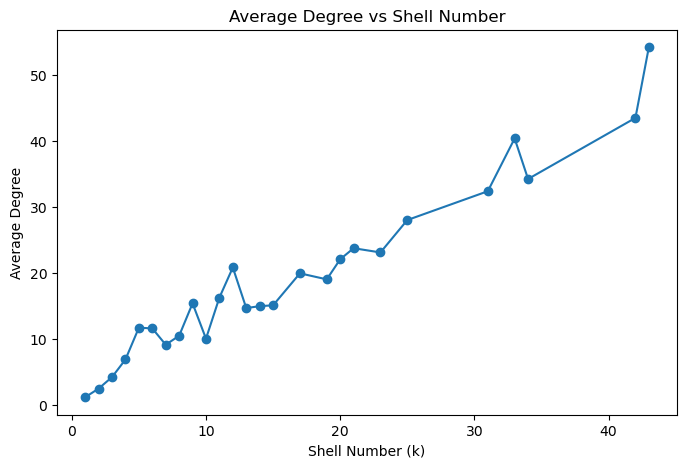

In [12]:
shell_avg_degree = {}

for node, k in core_numbers.items():
    deg = G_collab.degree(node)
    if k not in shell_avg_degree:
        shell_avg_degree[k] = []
    shell_avg_degree[k].append(deg)

avg_degrees = []
ks = sorted(shell_avg_degree.keys())

for k in ks:
    avg_degrees.append(np.mean(shell_avg_degree[k]))

plt.figure(figsize=(8, 5))
plt.plot(ks, avg_degrees, marker='o')
plt.xlabel("Shell Number (k)")
plt.ylabel("Average Degree")
plt.title("Average Degree vs Shell Number")
plt.show()

The plot of average degree versus shell number demonstrates the expected trend: nodes in higher shells tend to have higher average degrees, reflecting their position in more densely connected subgraphs. Notable irregularities include fluctuations in shells 10-15 and a dip at shell around 34, suggest heterogeneous substructures where some mid-level researchers form tight clusters while others bridge between core and periphery, reflecting varied collaboration strategies in the research network